In [1]:
import os
import torch
import pandas as pd
import pytorch_lightning as pl
import torch.nn.functional as F
import segmentation_models_pytorch as smp


from torch import nn
from tqdm import tqdm
from datasets import load_metric
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

/home/nplab/.local/lib/python3.8/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.23ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/home/nplab/.local/lib/python3.8/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.23ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(


In [2]:
class SkinDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.image_dir = os.path.join(root_dir, 'images')
        self.mask_dir = os.path.join(root_dir, 'masks')
        
        self.image_files = sorted([f for f in os.listdir(self.image_dir) if os.path.isfile(os.path.join(self.image_dir, f))])
        self.mask_files = sorted([f for f in os.listdir(self.mask_dir) if os.path.isfile(os.path.join(self.mask_dir, f))])
        
        self.transform = transform
        
    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_files[idx])

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")
        
        
        image = transforms.ToTensor()(image)
        mask = transforms.ToTensor()(mask)
        mask = (mask * 255).to(torch.uint8)
        return image, mask
    
        
transform = transforms.Compose([
    transforms.Resize((640, 640)),
    transforms.ToTensor()
])

train_data = SkinDataset(root_dir='../../../../Datasets/NewSkinDataset/original/train', transform=transform)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

for images, masks in train_loader:
    print(images.shape, masks.shape)
    break


torch.Size([32, 3, 640, 640]) torch.Size([32, 1, 640, 640])


In [3]:
import torch
import torch.nn.functional as F
from torch import nn
import pytorch_lightning as pl
import segmentation_models_pytorch as smp
from datasets import load_metric
from torchvision import transforms
from PIL import Image
import pandas as pd



class LitEfficientNet(pl.LightningModule):
    def __init__(self, train_dataloader=None, val_dataloader=None, test_dataloader=None, batch_size=32):
        super(LitEfficientNet, self).__init__()
        self.train_data_loader = train_dataloader
        self.val_data_loader = val_dataloader
        self.test_data_loader = test_dataloader
        self.model = smp.Unet(
            encoder_name="efficientnet-b0", 
            encoder_weights="imagenet", 
            in_channels=3, 
            classes=3
        )
        self.criterion = nn.CrossEntropyLoss()
        self.train_mean_iou = load_metric("mean_iou")
        self.val_mean_iou = load_metric("mean_iou")
        self.test_mean_iou = load_metric("mean_iou")
        self.batch_size = batch_size

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        preds = self(x)

        preds = preds.float()
        y = y.squeeze(1).long()

        loss = self.criterion(preds, y)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)

        preds_labels = torch.argmax(preds, dim=1).detach().cpu().numpy()
        y_true = y.detach().cpu().numpy()

        miou = self.val_mean_iou.compute(predictions=preds_labels.tolist(), 
                                         references=y_true.tolist(), 
                                         num_labels=3,
                                         ignore_index=255)['per_category_iou']
        miou_values = {
            'background_miou': miou[0],
            'pore_miou': miou[1],
            'wrinkle_miou': miou[2]
        }

        self.log('train_background_miou', miou[0], on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('train_pore_miou', miou[1], on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('train_wrinkle_miou', miou[2], on_step=True, on_epoch=True, prog_bar=True, logger=True)

        return {'loss' : loss}

    def validation_step(self, batch, batch_idx):
        x, y = batch
        preds = self(x)

        preds = preds.float()
        y = y.squeeze(1).long()

        loss = self.criterion(preds, y)
        self.log('val_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)

        preds_labels = torch.argmax(preds, dim=1).detach().cpu().numpy()
        y_true = y.detach().cpu().numpy()

        miou = self.val_mean_iou.compute(predictions=preds_labels.tolist(), 
                                         references=y_true.tolist(), 
                                         num_labels=3,
                                         ignore_index=255)['per_category_iou']
        miou_values = {
            'background_miou': miou[0],
            'pore_miou': miou[1],
            'wrinkle_miou': miou[2]
        }

        self.log('val_background_miou', miou[0], on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('val_pore_miou', miou[1], on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('val_wrinkle_miou', miou[2], on_step=True, on_epoch=True, prog_bar=True, logger=True)

        return {'val_loss' : loss}
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        preds = self(x)

        preds = preds.float()
        y = y.squeeze(1).long()

        loss = self.criterion(preds, y)
        self.log('test_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)

        preds_labels = torch.argmax(preds, dim=1).detach().cpu().numpy()
        y_true = y.detach().cpu().numpy()

        miou = self.val_mean_iou.compute(predictions=preds_labels.tolist(), 
                                         references=y_true.tolist(), 
                                         num_labels=3,
                                         ignore_index=255)['per_category_iou']
        miou_values = {
            'background_miou': miou[0],
            'pore_miou': miou[1],
            'wrinkle_miou': miou[2]
        }

        self.log('test_background_miou', miou[0], on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('test_pore_miou', miou[1], on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('test_wrinkle_miou', miou[2], on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return {'test_loss' : loss}

    
    def configure_optimizers(self):
        return torch.optim.Adam([p for p in self.parameters() if p.requires_grad], lr=1e-08, eps=1e-08)
    
    def train_dataloader(self):
        return self.train_data_loader
    
    def val_dataloader(self):
        return self.val_data_loader
    
    def test_dataloader(self):
        return self.test_data_loader


In [4]:
load_model = LitEfficientNet.load_from_checkpoint(checkpoint_path='./model_pt/2023_09_08_init_test.ckpt')


<ipython-input-3-bc40693990f4>:26: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  self.train_mean_iou = load_metric("mean_iou")


In [5]:
train_data = SkinDataset(root_dir='../../../../Datasets/NewSkinDataset/original/train', transform=transform)
train_loader = DataLoader(train_data, batch_size=1, shuffle=False)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


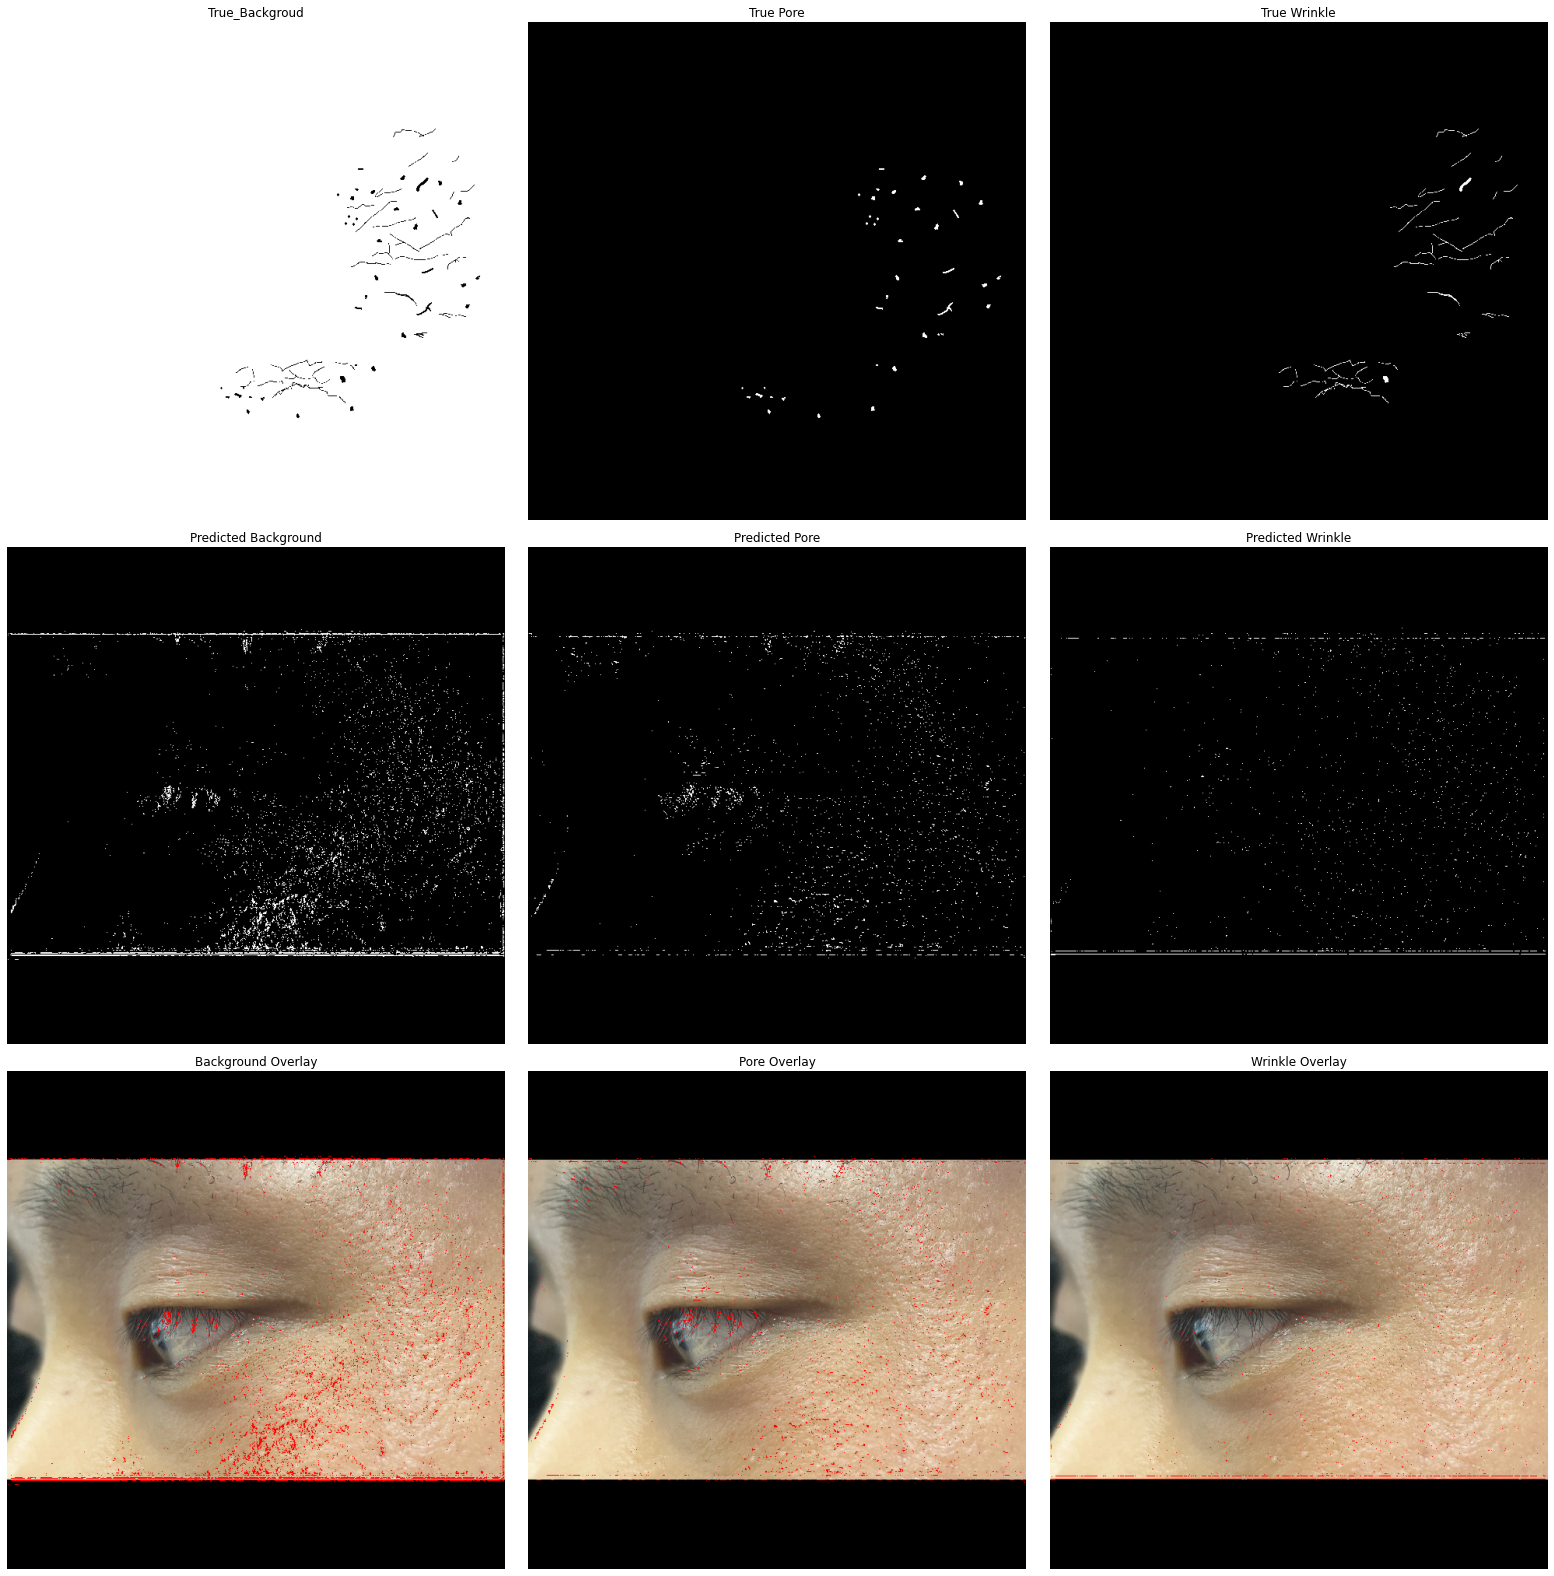

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


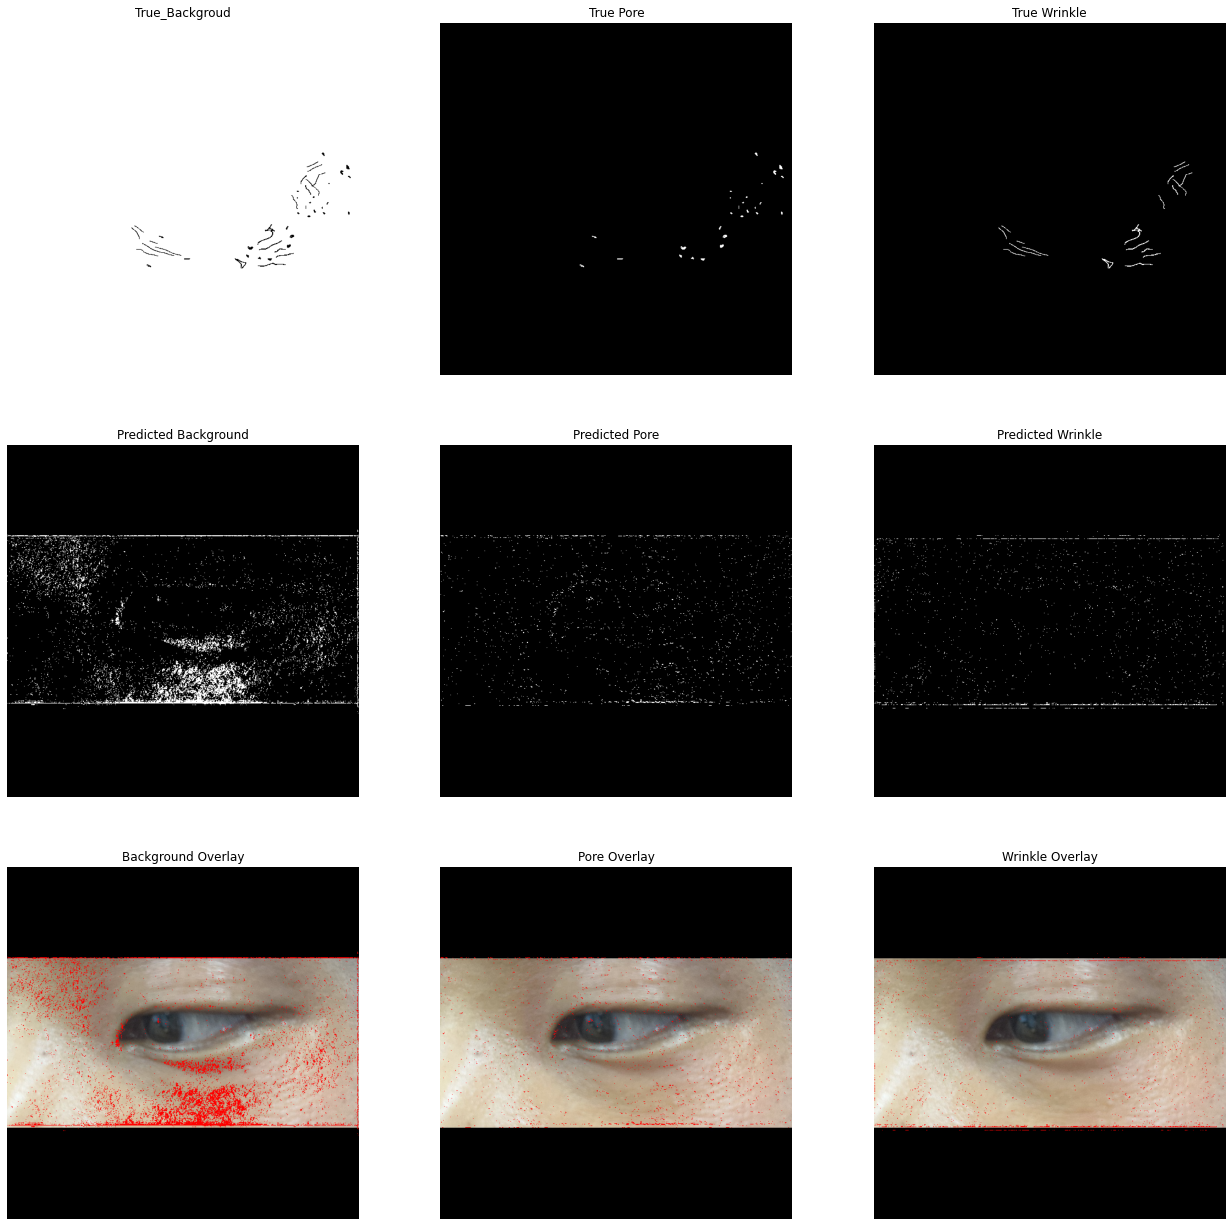

In [8]:
import matplotlib.pyplot as plt

for img_idx , batch in enumerate(train_loader):
    x, y = batch
    x, y = x.to('cpu'), y.to('cpu')
    logits = load_model(x)
    probs = torch.sigmoid(logits)

    to_plot = x.detach().cpu().numpy()
    y_true_plot = y.detach().cpu().numpy()
    y_pred_plot = (probs > 0.8).detach().cpu().numpy()

    fig, axs = plt.subplots(3, 3, figsize=(22, 22))


    for i, label in enumerate(['True_Backgroud', 'True Pore', 'True Wrinkle']):
        mask = y_true_plot[0][0] == (i)
        axs[0, i].imshow(mask, cmap='gray')
        axs[0, i].set_title(label)

    for i, label in enumerate(['Predicted Background', 'Predicted Pore', 'Predicted Wrinkle']):
        axs[1, i].imshow(y_pred_plot[0][i], cmap='gray')
        axs[1, i].set_title(label)

    for i, label in enumerate(['Background Overlay', 'Pore Overlay', 'Wrinkle Overlay']):
        overlay_image = to_plot[0].transpose((1, 2, 0)).copy()
        overlay_image[y_pred_plot[0][i] == 1] = [255, 0, 0]
        axs[2, i].imshow(overlay_image, cmap='gray')
        axs[2, i].set_title(label)
        
    #for i in range(3):
    #    axs[3, i].imshow(to_plot[0].transpose((1, 2, 0)), cmap='gray')
    #    axs[3, i].set_title('Input Image')


    for ax in axs.ravel():
        ax.axis('off')

    if img_idx > 0:
        break

    plt.tight_layout()
    plt.show()


In [9]:
from datasets import load_metric

metric = load_metric("mean_iou")
results = []

for img_idx , batch in tqdm(enumerate(train_loader)):
    x, y = batch
    x, y = x.to('cpu'), y.to('cpu')
    logits = load_model(x)
    probs = torch.sigmoid(logits)

    to_plot = x.detach().cpu().numpy()
    y_true_plot = y.detach().cpu().numpy()
    
    y_pred_plot = torch.argmax(probs, dim=1).detach().cpu().numpy()
    y_true_squeezed = y_true_plot[0].squeeze(0)
    
    miou_values = {}

    miou = metric.compute(predictions=[y_pred_plot[0]], 
                          references=[y_true_squeezed], 
                          num_labels=3, ignore_index = 255)['per_category_iou']

    miou_values['img_idx'] = img_idx
    miou_values['background_miou'] = miou[0]
    miou_values['pore_miou'] = miou[1]
    miou_values['wrinkle_miou'] = miou[2]
    results.append(miou_values)
    if img_idx > 0:
        break

miou_df = pd.DataFrame(results)
miou_df


1it [00:02,  2.36s/it]


,img_idx,background_miou,pore_miou,wrinkle_miou
0,0,0.237769,0.000651,0.002501
1,1,0.243535,0.000346,0.002344
